In [0]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [0]:
! pip install allennlp
! pip install seqeval

from allennlp.modules.conditional_random_field import ConditionalRandomField, allowed_transitions

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_sequence, pad_sequence, pack_padded_sequence, pad_packed_sequence, PackedSequence
from torch.utils.data.sampler import SubsetRandomSampler

import numpy as np
from time import time
from datetime import datetime

from pathlib import Path
from collections import Counter

from typing import List, Dict

from seqeval.metrics import f1_score, classification_report

In [0]:
%config InlineBackend.figure_format = 'svg'

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # default size of plots

In [0]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [0]:
# Code based on https://github.com/501Good/tartu-nlp-2020/blob/master/labs/lab5/Lab5_SequenceTagging.ipynb

class BaseVocab:
    def __init__(self, data, idx=0, lower=False):
        self.data = data
        self.lower = lower
        self.idx = idx
        self.build_vocab()
        
    def normalize_unit(self, unit):
        if self.lower:
            return unit.lower()
        else:
            return unit
        
    def unit2id(self, unit):
        unit = self.normalize_unit(unit)
        if unit in self._unit2id:
            return self._unit2id[unit]
        else:
            return self._unit2id[UNK]
    
    def id2unit(self, id):
        return self._id2unit[id]
    
    def map(self, units):
        return [self.unit2id(unit) for unit in units]

    def unmap(self, ids):
        return [self.id2unit(idx) for idx in ids]
        
    def build_vocab(self):
        NotImplementedError()
        
    def __len__(self):
        return len(self._unit2id)
    

In [0]:
class PretrainedWordVocab(BaseVocab):
    def build_vocab(self):
        self._id2unit = VOCAB_PREFIX + self.data
        self._unit2id = {w:i for i, w in enumerate(self._id2unit)}

In [0]:
class WordVocab(BaseVocab):
    def build_vocab(self):
        if self.lower:
            counter = Counter([w[self.idx].lower() for sent in self.data for w in sent])
        else:
            counter = Counter([w[self.idx] for sent in self.data for w in sent])

        self._id2unit = VOCAB_PREFIX + list(sorted(list(counter.keys()), key=lambda k: counter[k], reverse=True))
        self._unit2id = {w:i for i, w in enumerate(self._id2unit)}
        
    @property
    def items(self):
        return {i:w for i, w in enumerate(self._id2unit)}

In [0]:
class CharVocab(BaseVocab):
    def build_vocab(self):
        counter = Counter([c for sent in self.data for w in sent for c in w[self.idx]])
        self._id2unit = VOCAB_PREFIX + list(sorted(list(counter.keys()), key=lambda k: (counter[k], k), reverse=True))
        self._unit2id = {w:i for i, w in enumerate(self._id2unit)}

In [0]:
class Pretrain:
    def __init__(self, vec_filename):
        self._vec_filename = vec_filename
        
    @property
    def vocab(self):
        if not hasattr(self, '_vocab'):
            self._vocab, self._emb = self.read()
        return self._vocab
    
    @property
    def emb(self):
        if not hasattr(self, '_emb'):
            self._vocab, self._emb = self.read()
        return self._emb
        
    def read(self):
        if self._vec_filename is None:
            raise Exception("Vector file is not provided.")
        print(f"Reading pretrained vectors from {self._vec_filename}...")
        
        words, emb, failed = self.read_from_file(self._vec_filename, open_func=open)
        
        if failed > 0: # recover failure
            emb = emb[:-failed]
        if len(emb) - len(VOCAB_PREFIX) != len(words):
            raise Exception(f'Loaded number of vectors ({len(emb)}) does not match number of words ({len(words)}).')

        # Changed lower to False because fasttext embeddings are for cased tokens      
        vocab = PretrainedWordVocab(words, lower=False)
        
        return vocab, emb
        
    def read_from_file(self, filename, open_func=open):
        """
        Open a vector file using the provided function and read from it.
        """
        first = True
        words = []
        failed = 0
        with open_func(filename, 'rb') as f:
            for i, line in enumerate(f):
                try:
                    line = line.decode()
                except UnicodeDecodeError:
                    failed += 1
                    continue
                if first:
                    # the first line contains the number of word vectors and the dimensionality
                    first = False
                    line = line.strip().split(' ')
                    rows, cols = [int(x) for x in line]
                    emb = np.zeros((rows + len(VOCAB_PREFIX), cols), dtype=np.float32)
                    continue

                line = line.rstrip().split(' ')
                emb[i+len(VOCAB_PREFIX)-1-failed, :] = [float(x) for x in line[-cols:]]
                word = ' '.join(line[:-cols])
                words.append(word)

        print(f'Finished loading embeddings, failed to read {failed} vectors')

        return words, emb, failed

In [0]:
FIELD_NUM = 2

class Word:
    def __init__(self, word):
        self._text = word[0]
        self._label = word[1]

    @property
    def text(self):
        return self._text
    
    @property
    def label(self):
        return self._label


class Sentence:
    def __init__(self, words):
        self._words = [Word(w) for w in words]

    @property
    def words(self):
        return self._words

    
class Document:
    def __init__(self, file_path):
        self._sentences = []
        self.load_conll(open(file_path, encoding='utf-8'))


    def load_conll(self, f, ignore_gapping=False):
        """ Load the file or string into the CoNLL-U format data.
        Input: file or string reader, where the data is in CoNLL-U format.
        Output: a list of list of list for each token in each sentence in the data, where the innermost list represents 
        all fields of a token.
        """
        doc, sent = [], []
        for line in f:
            line = line.strip()
            if len(line) == 0:
                if len(sent) > 0:
                    doc.append(Sentence(sent))
                    sent = []
            else:
                if line.startswith('#'): # skip comment line
                    continue
                array = line.split('\t')
                if ignore_gapping and '.' in array[0]:
                    continue
                assert len(array) == FIELD_NUM, \
                        f"Cannot parse CoNLL line: expecting {FIELD_NUM} fields, {len(array)} found."
                sent += [array]
        if len(sent) > 0:
            doc.append(Sentence(sent))
        self._sentences = doc

    
    @property
    def sentences(self):
        return self._sentences


    def get(self, fields, as_sentences=False):
        assert isinstance(fields, list), "Must provide field names as a list."
        assert len(fields) >= 1, "Must have at least one field."

        results = []
        for sentence in self.sentences:
            cursent = []
            units = sentence.words
            for unit in units:
                if len(fields) == 1:
                    cursent += [getattr(unit, fields[0])]
                else:
                    cursent += [[getattr(unit, field) for field in fields]]

            # decide whether append the results as a sentence or a whole list
            if as_sentences:
                results.append(cursent)
            else:
                results += cursent
        return results

In [0]:
class CONLLUDataset(Dataset):
    def __init__(self, doc, pretrain, vocab=None, test=False):
        self.pretrain_vocab = pretrain.vocab
        self.test = test
        data = self.load_doc(doc)

        if vocab is None:
            self.vocab = self.init_vocab(data)
        else:
            self.vocab = vocab

        self.data = self.preprocess(data, self.vocab, self.pretrain_vocab)

    def init_vocab(self, data):
        wordvocab = WordVocab(data, idx=0)
        charvocab = CharVocab(data, idx=0)
        labelvocab = WordVocab(data, idx=1)
        vocab = {
            'word': wordvocab,
            'char': charvocab,
            'label': labelvocab}
        return vocab

    def preprocess(self, data, vocab, pretrain_vocab):
        processed = []
        for sent in data:
            processed_sent = [vocab['word'].map([w[0] for w in sent])]
            processed_sent += [[vocab['char'].map([char for char in w[0]]) for w in sent]]
            processed_sent += [vocab['label'].map([w[1] for w in sent])]
            processed_sent += [pretrain_vocab.map([w[0] for w in sent])]
            processed.append(processed_sent)
        return processed
        
    def load_doc(self, doc):
        data = doc.get(['text', 'label'], as_sentences=True)
        return data
            
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx]

In [0]:
def pad_collate(batch):
    (sents, chars, labels, pretrained) = zip(*batch)

    sent_lens = [len(s) for s in sents]
    word_lens = [len(c) for w in chars for c in w]

    sents = [torch.LongTensor(w).to(device) for w in sents]
    chars = [torch.LongTensor(c).to(device) for w in chars for c in w]
    labels = [torch.LongTensor(label).to(device) for label in labels]
    pretrained = [torch.LongTensor(p).to(device) for p in pretrained]

    sent_pad = pad_sequence(sents, batch_first=True, padding_value=PAD_ID)
    chars_pad = pad_sequence(chars, batch_first=True, padding_value=PAD_ID)
    label_pad = pad_sequence(labels, batch_first=True, padding_value=PAD_ID)
    pretrained_pad = pad_sequence(pretrained, batch_first=True, padding_value=PAD_ID)

    sent_pad = sent_pad.to(device)
    chars_pad = chars_pad.to(device)
    label_pad = label_pad.to(device)
    pretrained_pad = pretrained_pad.to(device)

    return sent_pad, chars_pad, label_pad, pretrained_pad, sent_lens, word_lens

In [0]:
# Code based on https://github.com/ahmedbesbes/character-based-cnn/blob/master/src/model.py
# and https://github.com/jiesutd/NCRFpp/blob/master/model/charcnn.py
class CharCNN(nn.Module):
    def __init__(self, vocab, char_emb_dim, char_hidden_dim, dropout):        
        super().__init__()       
        self.char_emb = nn.Embedding(len(vocab['char']), char_emb_dim, padding_idx=PAD_ID)  
        self.char_emb.weight.data.copy_(torch.from_numpy(self.random_embedding(len(vocab['char']), 
                                                                                    char_emb_dim)))

        self.conv = nn.Conv1d(in_channels = char_emb_dim, 
                              out_channels=char_hidden_dim, 
                              kernel_size=3, padding=1)
        
        self.dropout = nn.Dropout(dropout)
        
    def random_embedding(self, vocab_size, char_emb_dim):
        pretrain_emb = np.empty([vocab_size, char_emb_dim])
        scale = np.sqrt(3.0 / char_emb_dim)
        for index in range(vocab_size):
            pretrain_emb[index,:] = np.random.uniform(-scale, scale, 
                                                      [1, char_emb_dim])
        return pretrain_emb
        
    def forward(self, chars_pad):       
        char_emb = self.dropout(self.char_emb(chars_pad))        
        char_emb = char_emb.transpose(2,1).contiguous()
       
        batch_size = char_emb.size(0)
        
        x = self.conv(char_emb) 
        
        # Take the max over the entire sequence
        out = F.max_pool1d(x, x.size(2))
        
        # Remove the third dimension (of shape 1)
        result = out.view(batch_size, -1)          
        return result

In [0]:
class Tagger(nn.Module):
    def __init__(self, vocab: Dict[str, BaseVocab], word_emb_dim: int,
                 char_emb_dim: int, transformed_dim: int, emb_matrix: np.ndarray, 
                 hidden_dim: int, char_hidden_dim: int, num_layers: int, dropout: int):
        super().__init__()

        self.vocab = vocab
        self.num_layers = num_layers
        self.hidden_dim = hidden_dim

        input_size = 0
        
        self.char_model = CharCNN(vocab, char_emb_dim, char_hidden_dim, dropout)
        
        input_size += char_hidden_dim

        # Trainable word embedding layer with random initialization
        self.word_emb = nn.Embedding(len(vocab['word']), word_emb_dim, padding_idx=PAD_ID)
        self.word_emb.weight.data.copy_(torch.from_numpy(self.random_embedding(len(vocab['word']), 
                                                                               word_emb_dim)))
        input_size += word_emb_dim

        self.pretrained_emb = nn.Embedding.from_pretrained(torch.from_numpy(emb_matrix), freeze=True)

        input_size += emb_matrix.shape[1]

        self.lstm = nn.LSTM(input_size, hidden_dim, num_layers, batch_first=True, bidirectional=True)
        
        # Hidden-to-label linear layer (2* is because of the bidirectionality)
        self.label_clf = nn.Linear(2* hidden_dim, len(vocab['label']))

        # Add CRF layer, extracting constraints according to label scheme
        #'BIOUL'
        self.crf = ConditionalRandomField(len(vocab['label']), constraints=allowed_transitions('BIO', vocab['label'].items))

        self.drop = nn.Dropout(dropout)

    def random_embedding(self, vocab_size, embedding_dim):
        pretrain_emb = np.empty([vocab_size, embedding_dim])
        scale = np.sqrt(3.0 / embedding_dim)
        for index in range(vocab_size):
            pretrain_emb[index,:] = np.random.uniform(-scale, scale, [1, embedding_dim])
        return pretrain_emb

    def forward(self, sent_pad, chars_pad, label_pad, pretrained_pad, sent_lens, word_lens):
        inputs = []

        # Trainable word embeddings
        word_emb = self.drop(self.word_emb(sent_pad))
        inputs += [word_emb]

        pretrained_emb = self.drop(self.pretrained_emb(pretrained_pad))

        # Pretrained word emb shape after transform: [batch_size, seq_length, transformed_dim]
        inputs += [pretrained_emb]
        
        char_emb = self.char_model(chars_pad)
               
        # Split the char embedding into sentences and return the padded version
        char_emb = pad_sequence(char_emb.split(sent_lens), batch_first=True, padding_value=PAD_ID)
        inputs += [char_emb]
        # Char emb shape after transform: [batch_size, seq_length, transformed_dim]
        
        # Concatenate the embeddings
        lstm_inputs = torch.cat([x for x in inputs], 2)
        lstm_inputs = self.drop(lstm_inputs)
        lstm_inputs = pack_padded_sequence(lstm_inputs, sent_lens, batch_first=True, enforce_sorted=False)
        # LSTM inputs shape: [seq_length, concatenation of embeddings]
        
        lstm_outputs, _ = self.lstm(lstm_inputs)
        lstm_outputs, _ = pad_packed_sequence(lstm_outputs, batch_first=True)
        # LSTM outputs shape: [seq_length, 2*hidden_dim]

        pred = self.label_clf(self.drop(lstm_outputs))
        
        # Replace the softmax probs with Viterbi-generated most likely tags
        mask = label_pad != PAD_ID
        # Mask shape: [batch_size, seq_length]
        label_pred = self.crf.viterbi_tags(pred, mask)
        
        # Extract tag sequences for each example in the batch
        tag_seqs = [result[0] for result in label_pred]
        # Convert the predicted tag sequences into a tensor and pad if necessary
        tag_seqs = [torch.LongTensor(seq).to(device) for seq in tag_seqs]
        tag_seqs_pad = pad_sequence(tag_seqs, batch_first=True, padding_value=PAD_ID)
        
        # Replace softmax+ce loss with the negative of CRF log-likelihood
        # Label_pad shape: [batch_size, seq_length]
        loss = -self.crf(pred, label_pad, mask)

        return loss, tag_seqs_pad

In [0]:
class Trainer:
    def __init__(self, vocab, word_emb_dim, char_emb_dim, transformed_dim,
                 emb_matrix, hidden_dim, char_hidden_dim, num_layers, dropout, 
                 init_lr, lr_decay):
        self.vocab = vocab
        self.model = Tagger(vocab, word_emb_dim, char_emb_dim, transformed_dim, 
                            emb_matrix, hidden_dim, char_hidden_dim, num_layers, dropout)
        self.parameters = [p for p in self.model.parameters() if p.requires_grad]

        self.model.to(device)

        self.init_lr = init_lr
        self.lr_decay = lr_decay
        
        self.optimizer = torch.optim.Adam(self.parameters)
        
    def update(self, batch, eval=False):
        sent_pad, chars_pad, label_pad, pretrained_pad, sent_lens, word_lens = batch

        if eval:
            self.model.eval()
        else:
            self.model.train()
            self.optimizer.zero_grad()

        loss, _ = self.model(sent_pad, chars_pad, label_pad, pretrained_pad, sent_lens, word_lens)
        loss_val = loss.data.item()
        if eval:
            return loss_val

        loss.backward()
        self.optimizer.step()

        return loss_val

    def predict(self, batch):
        sent_pad, chars_pad, label_pad, pretrained_pad, sent_lens, word_lens = batch

        self.model.eval()
        batch_size = sent_pad.size(0)
        _, pred = self.model(sent_pad, chars_pad, label_pad, pretrained_pad, sent_lens, word_lens)
        
        # Transform the indices to the NER-labels
        pred = [self.vocab['label'].unmap(sent) for sent in pred.tolist()]
        # Trim the predictions to their original lengths
        pred_tokens = [[pred[i][j] for j in range(sent_lens[i])] for i in range(batch_size)]
        gold_labels = [vocab['label'].unmap(label) for label in [label for label in label_pad]]
        gold_tokens = [[gold_labels[i][j] for j in range(sent_lens[i])] for i in range(batch_size)]

        return pred_tokens, gold_tokens
      
    def evaluate(self, iterator, test=False):    
        epoch_loss = 0

        preds = []
        golds = []
        words = []
        
        self.model.eval()     
        with torch.no_grad():     
            for batch in iterator:
                batch_size = batch[0].size(0)
                pred, gold = self.predict(batch)
                
                # Extend because predict outputs lists of lists already
                preds.extend(pred)
                golds.extend(gold)

                # Keep the original sentence
                pred_sents = [[batch[0][i][j] for j in range(batch[4][i])] for i in range(batch_size)]
                words.extend([vocab['word'].unmap(sent) for sent in [sent for sent in pred_sents]])
                
                loss = self.update(batch, eval=True) 
                epoch_loss += loss

            #golds_converted = self.bilou_to_bioes(golds)
            #preds_converted = self.bilou_to_bioes(preds)

            #score = f1_score(golds_converted, preds_converted)
            score = f1_score(golds, preds)
            if test:
              #report = classification_report(golds_converted, preds_converted, digits=3)
              report = classification_report(golds, preds, digits=3)
            else:
              report = ''
        
        loss = epoch_loss / len(iterator)
            
        return loss, score, words, preds, report

    def bilou_to_bioes(self, input):
      output = []
      for label_list in input:
        output_list = []
        for label in label_list:
          split = label.split('-')
          if len(split) > 1:
            if split[0] == 'U':
              output_list.append(f'S-{split[1]}')
              continue
            elif split[0] == 'L':
              output_list.append(f'E-{split[1]}')
              continue
          output_list.append(label)
        output.append(output_list)
      return output

In [0]:
# Code taken from https://github.com/Bjarten/early-stopping-pytorch/blob/master/pytorchtools.py
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'Early stopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), DATA_PATH / 'regular_checkpoint.pt')
        self.val_loss_min = val_loss

In [0]:
PAD = '<PAD>'
PAD_ID = 0
UNK = '<UNK>'
UNK_ID = 1
VOCAB_PREFIX = [PAD, UNK]

VEC_PATH = Path('drive') / 'My Drive' / 'data' / 'estonian_fasttext' / 'cc.et.300.vec'
DATA_PATH = Path('drive') / 'My Drive' / 'data' / 'project_estner'

BATCH_SIZE = 64
shuffle_dataset = True
random_seed = 42

In [0]:
pretrain = Pretrain(VEC_PATH)

In [0]:
#train_doc = Document(DATA_PATH / 'project_train_bilou.txt')
train_doc = Document(DATA_PATH / 'project_train.txt')

In [0]:
train_dataset = CONLLUDataset(train_doc, pretrain)

Reading pretrained vectors from drive/My Drive/data/estonian_fasttext/cc.et.300.vec...
Finished loading embeddings, failed to read 0 vectors


In [0]:
vocab = train_dataset.vocab
#dev_doc = Document(DATA_PATH / 'project_dev_bilou.txt')
dev_doc = Document(DATA_PATH / 'project_dev.txt')
dev_dataset = CONLLUDataset(dev_doc, pretrain, vocab=vocab, test=True)

In [0]:
train_subset = train_dataset[:100]

In [0]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=shuffle_dataset, collate_fn=pad_collate)
small_train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=shuffle_dataset, collate_fn=pad_collate)
dev_loader = DataLoader(dev_dataset, batch_size=BATCH_SIZE, shuffle=shuffle_dataset, collate_fn=pad_collate)

In [0]:
word_emb_dim = 100 # Yang et al.
char_emb_dim = 30 # Yang et al.
transformed_dim = 125
emb_matrix = pretrain.emb
print(f'Shape of emb matrix: {emb_matrix.shape}')
hidden_dim = 100 # Since we use a bi-LSTM -> in total 100 x 2
char_hidden_dim = 50 # Yang et al.
num_layers = 1
char_num_layers = 1
dropout = 0.5

Shape of emb matrix: (2000002, 300)


In [0]:
init_lr=0.015
lr_decay=0.05

In [0]:
trainer = Trainer(vocab, word_emb_dim, char_emb_dim, transformed_dim,
                  emb_matrix, hidden_dim, char_hidden_dim,
                  num_layers, dropout, init_lr, lr_decay)

In [0]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters if p.requires_grad)

print(f'The model has {count_parameters(trainer):,} trainable parameters')

The model has 2,585,380 trainable parameters


In [0]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [0]:
# Code taken from https://github.com/jiesutd/NCRFpp/blob/master/main.py
def decay_learning_rate(optimizer, epoch, decay_rate, init_lr):
    lr = init_lr/(1+decay_rate*epoch)
    print(" Learning rate is set as:", lr)
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    return optimizer

In [0]:
global_step = 0
max_steps = 10000000
dev_score_history = []
train_loss_history = []
dev_loss_history = []
format_str = '{}: step {}/{}, loss = {:.6f} ({:.3f} sec/batch)'
last_best_step = 0

log_step = 100
eval_interval = 500

epochs = 30
patience = 7

In [0]:
train_loss = 0

# initialize the early_stopping object
early_stopping = EarlyStopping(patience=patience, verbose=True)

for idx in range(epochs):
    print(f'Epoch: {idx+1}/{epochs}')
    epoch_start = time()
    #trainer.optimizer = decay_learning_rate(trainer.optimizer, idx, trainer.lr_decay, trainer.init_lr)
    for batch in train_loader:
        start_time = time()
        global_step += 1
        loss = trainer.update(batch, eval=False)
        train_loss += loss

        if global_step % log_step == 0:
            duration = time() - start_time
            print(format_str.format(datetime.now().strftime("%Y-%m-%d %H:%M:%S"), global_step,\
                    max_steps, loss, duration))     
        

    # Evaluation after each epoch
    print('Evaluating on dev set...')
    dev_loss, dev_score, dev_words, dev_preds, dev_report = trainer.evaluate(dev_loader)
          
    # Calculate losses and span-based f1-score
    dev_score_history.append(dev_score)
    train_loss = train_loss / len(train_loader)
    train_loss_history.append(train_loss)
    dev_loss_history.append(dev_loss)
    print("step {}: train_loss = {:.6f}, dev_score = {:.6f}".format(global_step, train_loss, dev_score))

    # Show one prediction for a sanity check
    print(f'Preds: {list(zip(dev_preds[0], dev_words[0]))}')
    train_loss = 0

    epoch_end = time()
    epoch_mins, epoch_secs = epoch_time(epoch_start, epoch_end)
    print(f'Training epoch took: {epoch_mins}m {epoch_secs}s')
    
    # Early_stopping needs the validation loss to check if it has decreased, 
    # and if it has, it will make a checkpoint of the current model
    early_stopping(dev_loss, trainer.model)
    
    if early_stopping.early_stop:
        print("Early stopping")
        break
        

Epoch: 1/30
2020-05-28 16:45:36: step 100/10000000, loss = 525.253845 (0.154 sec/batch)
Evaluating on dev set...
step 162: train_loss = 670.939462, dev_score = 0.022907
Preds: [('O', '”'), ('O', '<UNK>'), ('O', 'avab'), ('O', 'oma'), ('O', 'rahakoti'), ('O', ','), ('O', 'et'), ('O', 'aidata'), ('O', 'Ida-Euroopa'), ('O', '<UNK>'), ('O', '<UNK>'), ('O', '<UNK>'), ('O', '<UNK>'), ('O', 'ja'), ('O', 'ühtlasi'), ('O', 'näidata'), ('O', ','), ('O', 'kuidas'), ('O', 'kasutada'), ('O', 'hiljem'), ('O', '<UNK>'), ('O', 'Euroopa'), ('O', 'Liidu'), ('O', '<UNK>'), ('O', '<UNK>'), ('O', '.')]
Training epoch took: 0m 45s
Validation loss decreased (inf --> 357.913012).  Saving model ...
Epoch: 2/30
2020-05-28 16:47:36: step 200/10000000, loss = 320.449768 (0.173 sec/batch)
2020-05-28 16:48:03: step 300/10000000, loss = 319.746704 (0.186 sec/batch)
Evaluating on dev set...
step 324: train_loss = 377.033743, dev_score = 0.353856
Preds: [('O', 'Eks'), ('O', '<UNK>'), ('O', 'ole'), ('O', 'omad'), ('O',

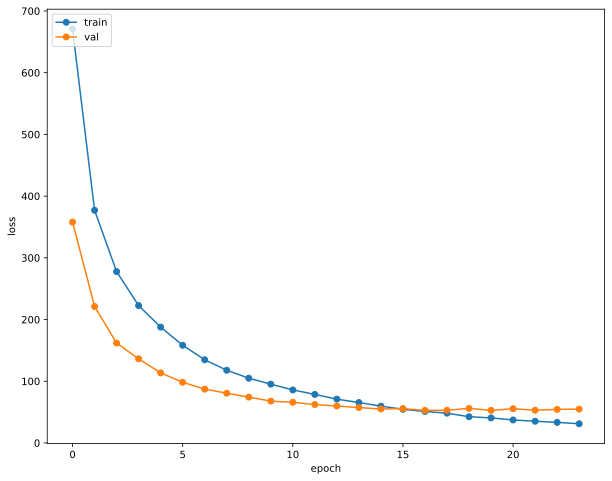

In [0]:
plt.plot(train_loss_history, '-o')
plt.plot(dev_loss_history, '-o')
plt.legend(['train', 'val'], loc='upper left')
plt.xlabel('epoch')
plt.ylabel('loss')
#plt.savefig(DATA_PATH / 'regular_adam_losses.svg')

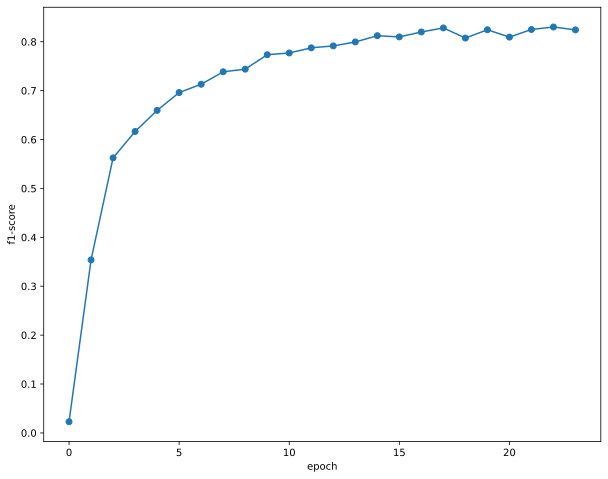

In [0]:
plt.plot(dev_score_history, '-o')
plt.xlabel('epoch')
plt.ylabel('f1-score')
#plt.savefig(DATA_PATH / 'regular_adam_dev_fscore.svg')

In [0]:
# Load the last checkpoint with the best model
trainer.model.load_state_dict(torch.load(DATA_PATH / 'regular_checkpoint.pt'))

<All keys matched successfully>

In [0]:
# Read the test set and evaluate on that
#test_doc = Document(DATA_PATH / 'project_test_manual_corrs_bilou.txt')
test_doc = Document(DATA_PATH / 'project_test_manual_corrs.txt')
test_dataset = CONLLUDataset(test_doc, pretrain, vocab=vocab, test=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=shuffle_dataset, collate_fn=pad_collate)

In [0]:
test_loss, test_score, test_words, test_preds, test_report = trainer.evaluate(test_loader, test=True)

In [0]:
test_score

0.7962962962962963

In [0]:
from pprint import pprint
pprint(test_report)

('           precision    recall  f1-score   support\n'
 '\n'
 '      ORG      0.711     0.660     0.684       626\n'
 '      LOC      0.877     0.810     0.842       825\n'
 '      PER      0.844     0.821     0.832       883\n'
 '\n'
 'micro avg      0.820     0.774     0.796      2334\n'
 'macro avg      0.820     0.774     0.796      2334\n')


In [0]:
import os

output_dir = DATA_PATH / 'model'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

output_file = output_dir / 'latest_ner.bin'

torch.save(trainer.model.state_dict(), output_file)

# To load the saved state later:
#the_model = TheModelClass(*args, **kwargs)
#the_model.load_state_dict(torch.load(PATH))

In [0]:
# Test whether the model can overfit on small subset of data

trainer = Trainer(vocab, word_emb_dim, char_emb_dim, transformed_dim,
                  emb_matrix, hidden_dim, char_hidden_dim, label_clf_hidden_dim,
                  num_layers, dropout)

epochs = 100
eval_interval = 100
global_step = 0
train_loss = 0
for idx in range(epochs):
    #print(f'Epoch: {idx+1}/{epochs}')
    for batch in small_train_loader:
        start_time = time()
        global_step += 1
        loss = trainer.update(batch, eval=False)
        train_loss += loss

        if global_step % log_step == 0:
            duration = time() - start_time
            print(format_str.format(datetime.now().strftime("%Y-%m-%d %H:%M:%S"), global_step,\
                    max_steps, loss, duration))
            
        if global_step % eval_interval == 0 or global_step == max_steps:
            print('Evaluating on train set...')
            train_loss, train_score, train_words, train_preds = trainer.evaluate(small_train_loader)
            
            print('Evaluating on dev set...')
            dev_loss, dev_score, dev_words, dev_preds = trainer.evaluate(dev_loader)

            print("step {}: train_score = {:.6f}, dev_score = {:.6f}".format(global_step, train_score, dev_score))
            # Shows one prediction for a sanity check
            print(f'Preds: {list(zip(dev_preds[0], dev_words[0]))}')
            train_loss = 0